In [1]:
library(ggplot2)
library(gridExtra)
library(lindia)
library(repr)

In [2]:
custom.panel <- function() {
     axis(1, tck = 1, col.ticks = "light gray")
     axis(1, tck = -0.015, col.ticks = "black")
     axis(2, tck = 1, col.ticks = "light gray")
     axis(2, tck = -0.015)
}

In [3]:
x <- read.table("X.txt")
y <- data.frame(value = scan("Y.txt"))

data <- cbind(x, y)
size <- nrow(data)
head(data)

V1,V2,V3,V4,value
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
252.36,96.67,8.37,1,142.0114
262.54,100.07,9.07,1,149.2133
285.70,96.78,9.35,1,160.5137
277.52,101.30,9.67,1,160.6265
307.95,100.35,9.45,1,171.7838
322.44,104.80,10.12,1,176.6336


### Linear models

In [4]:
options(repr.plot.width = 15, repr.plot.height = 5)

l.model <- lm(value ~ V1 + V2 + V3, data=data)
coeffs <- coefficients(l.model)

summary(l.model)


Call:
lm(formula = value ~ V1 + V2 + V3, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3546 -1.4289  0.1966  1.1429  2.6701 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.451297  18.174378   0.080    0.938    
V1           0.370165   0.028833  12.838 5.79e-08 ***
V2          -0.003005   0.272945  -0.011    0.991    
V3           5.711274   0.883582   6.464 4.65e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.845 on 11 degrees of freedom
Multiple R-squared:  0.9964,	Adjusted R-squared:  0.9954 
F-statistic:  1019 on 3 and 11 DF,  p-value: 9.976e-14


In [5]:
inds <- seq(0, length(data$value) - 1)
data.result <- data.frame(ind = inds, 
                          y = data$value, 
                          y_hat = predict(l.model))
data.result

ind,y,y_hat
<int>,<dbl>,<dbl>
0,142.0114,142.3791
1,149.2133,150.1351
2,160.5137,160.3171
3,160.6265,159.1032
4,171.7838,169.1137
5,176.6336,178.2906
6,184.9674,184.2049
7,191.3625,193.7171
8,186.4050,188.5346


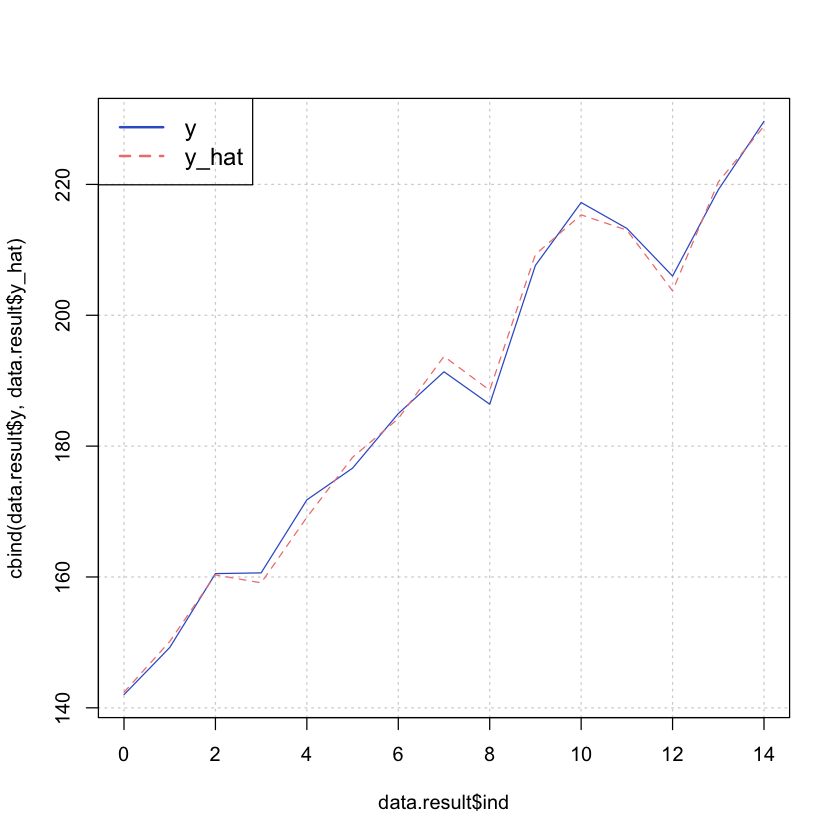

In [75]:
options(repr.plot.width = 7, repr.plot.height = 7)
matplot(data.result$ind, cbind(data.result$y, data.result$y_hat), 
        col = c('royalblue3', 'lightcoral'),
        pch = 19,
        type = 'l',
        panel.first = grid())
legend("topleft", c("y", "y_hat"), col = c('royalblue3', 'lightcoral'),
       lty = c(1, 2), lwd = c(2, 2), cex = 1.2)

#### Estimation of residuals variance

In [7]:
s.squared <- sum((fitted(l.model) - data$value)^2) / (size - 4 - 1)
s.squared

[1] 3.7438

#### SSE

In [8]:
sum((fitted(l.model) - data$value)^2) / 2

[1] 18.719

### Residuals

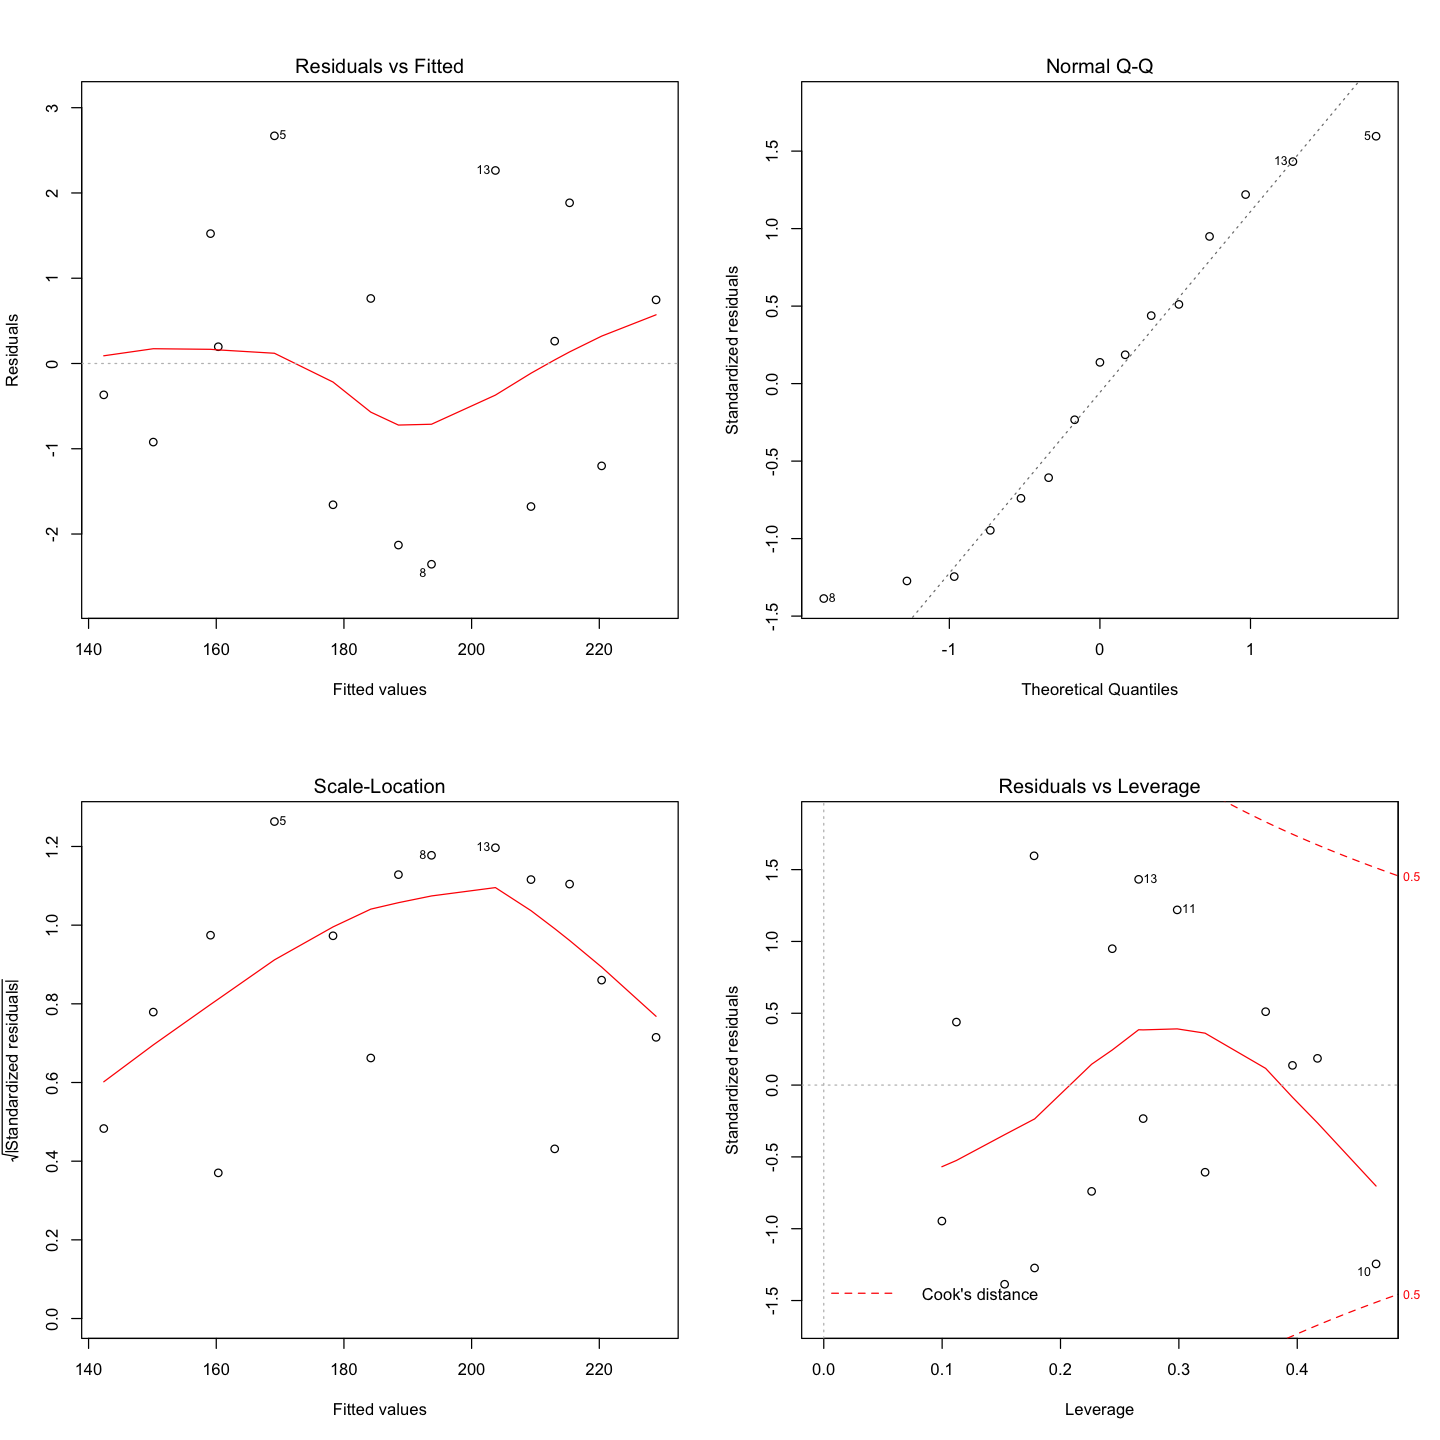

In [9]:
options(repr.plot.width = 12, repr.plot.height = 12)
par(mfrow = c(2, 2))

plot(l.model)

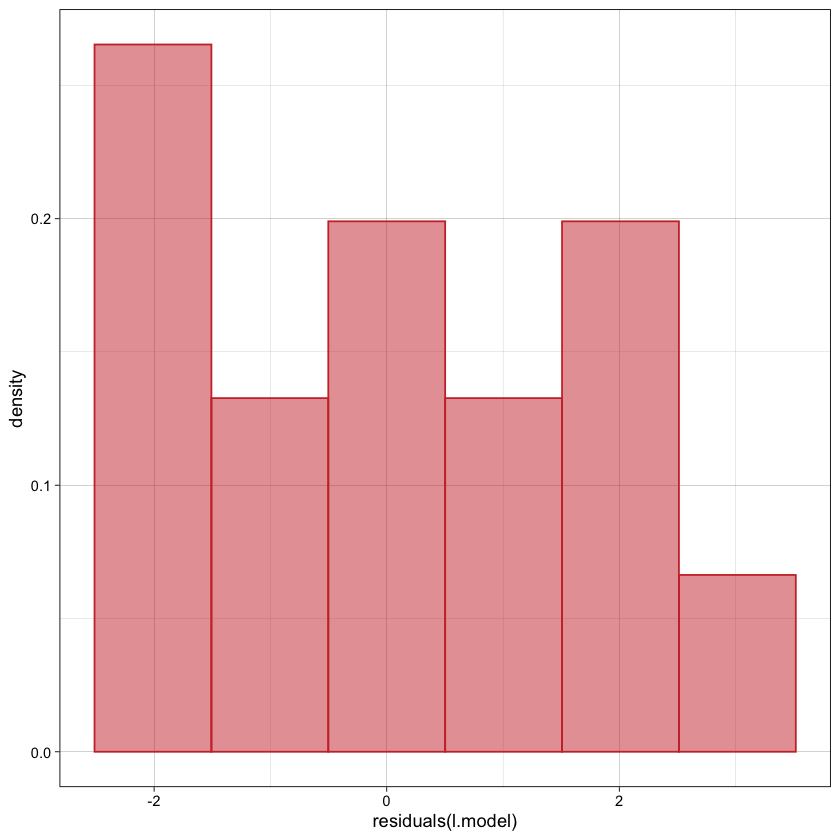

In [10]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(as.data.frame(residuals(l.model)), aes(x = residuals(l.model))) + 
       geom_histogram(bins = 6, aes(y = ..density..), 
                      color = "brown3", 
                      fill = "brown3",
                      alpha = .5) +
       theme_linedraw()

In [11]:
mean(residuals(l.model))

[1] -5.922635e-17

### cov

In [30]:
cov_custom <- function(M) {
    X <- as.matrix(M)
    return (as.double(s.squared) * solve(t(X) %*% X))
}
data.cov <- cov_custom(data[, c(1, 2, 3, 4)])
data.cov

,V1,V2,V3,V4
V1,0.0009144531,-0.005259602,-0.007655145,0.3315861
V2,-0.0052596019,0.081949126,-0.144410150,-5.3577108
V3,-0.0076551448,-0.144410150,0.858789469,8.6382403
V4,0.3315860754,-5.357710819,8.638240257,363.3388353


### cor

In [27]:
cor_custom <- function(M) {
    X <- as.matrix(M)
    k <- ncol(M) # Number of variables

    M.cor <-  matrix(data = 1, nrow = k, ncol = k)
    M.cov <- solve(t(X) %*% X)
    
    for (i in seq(1, k)) {
        for (j in seq(1, k)) {
            M.cor[i, j] <- M.cov[i, j] / (sqrt(M.cov[i, i] * M.cov[j, j]))
        }
    }
    colnames(M.cor) <- colnames(M)
    rownames(M.cor) <- colnames(M)
    
    return(M.cor)
}

In [28]:
data.cor <- cor_custom(data[, c(1, 2, 3, 4)])
data.cor

,V1,V2,V3,V4
V1,1.0000000,-0.6075751,-0.2731677,0.5752540
V2,-0.6075751,1.0000000,-0.5443550,-0.9818637
V3,-0.2731677,-0.5443550,1.0000000,0.4890193
V4,0.5752540,-0.9818637,0.4890193,1.0000000


### Determination coefficient

In [57]:
SS.reg <- sum((predict(l.model) - mean(data$value))^2)
SS.tot <- sum((data$value - mean(data$value))^2)
R <- SS.reg / SS.tot
R

[1] 0.9964159

In [58]:
n <- dim(data)[1]
m <- dim(data)[2] - 1
R.adj <- (R * (n - 1) - m + 1) / (n - m )
R.adj

[1] 0.9954385

In [59]:
summary(l.model)$r.squared

[1] 0.9964159

### Hypothesis testing

In [60]:
library(matlib)

In [61]:
X <- as.matrix(data[, 1:4])
XXt.inv <- inv(t(X) %*% X)

A <- l.model$coefficients

In [62]:
XXt.inv

,,,
0.00024426,-0.00140488,-0.00204475,0.08856939
-0.00140488,0.02188929,-0.03857315,-1.43108893
-0.00204475,-0.03857315,0.22938978,2.30734551
0.08856939,-1.43108893,2.30734551,97.05081207


In [63]:
get_t_stat <- function(s, Xinvprod, coeff) {
    s.n <- sqrt(s) * sqrt(Xinvprod)
    t.stat = coeff / s.n
    
    return(t.stat)
}

In [90]:
A

(Intercept)          V1          V2          V3 
 1.45129741  0.37016531 -0.00300485  5.71127387

In [65]:
alpha = 0.05
qt(1 - alpha / 2, 11)

[1] 2.200985

In [66]:
alpha = 0.25
qt(1 - alpha / 2, 11)

[1] 1.21446

In [94]:
t.1th <- get_t_stat(s.squared, XXt.inv[4, 4], A[[1]])
t.1th

0.07613783

In [95]:
t.2st <- get_t_stat(s.squared, XXt.inv[1, 1], A[[2]])
t.2st

12.2409

In [96]:
t.3nd <- get_t_stat(s.squared, XXt.inv[2, 2], A[[3]])
t.3nd

-0.01049665

In [97]:
t.4rd <- get_t_stat(s.squared, XXt.inv[3, 3], A[[4]])
t.4rd

6.162964

### Reduced model (no A[[3]])

In [98]:
options(repr.plot.width = 15, repr.plot.height = 5)

l.model_reduced <- lm(value ~ V1 + V3, data=data)
coeffs <- coefficients(l.model_reduced)

summary(l.model_reduced)


Call:
lm(formula = value ~ V1 + V3, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3603 -1.4319  0.2069  1.1397  2.6745 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.25484    3.29898   0.380     0.71    
V1           0.36997    0.02193  16.874 1.00e-09 ***
V3           5.70598    0.70965   8.041 3.57e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.766 on 12 degrees of freedom
Multiple R-squared:  0.9964,	Adjusted R-squared:  0.9958 
F-statistic:  1668 on 2 and 12 DF,  p-value: 2.12e-15


In [99]:
inds <- seq(0, length(data$value) - 1)
data.result_reduced <- data.frame(ind = inds, 
                                  y = data$value, 
                                  y_hat = predict(l.model_reduced))

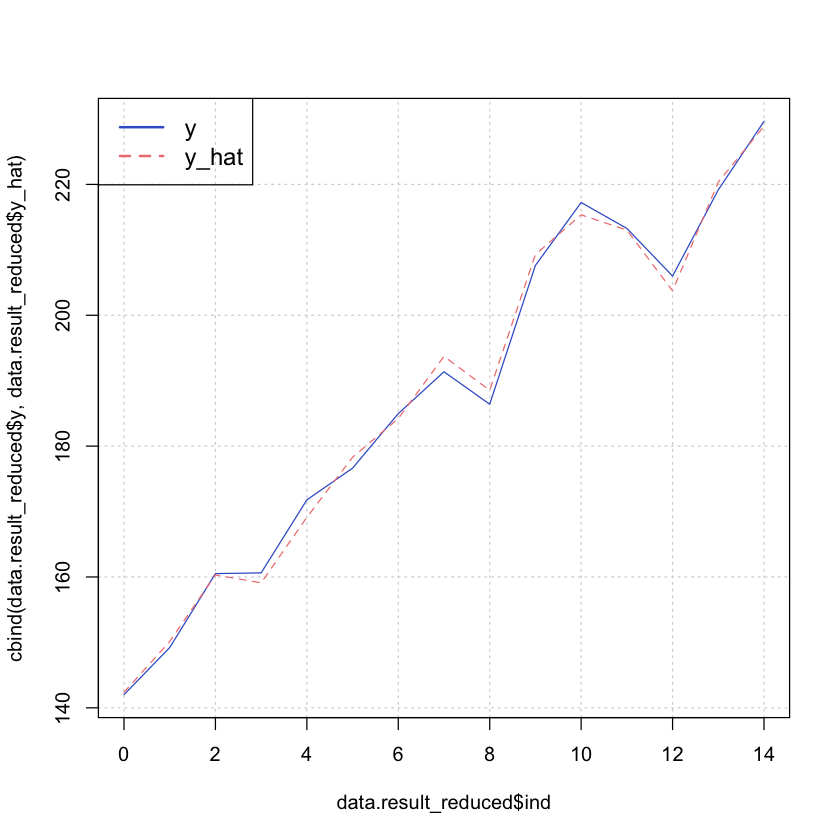

In [100]:
options(repr.plot.width = 7, repr.plot.height = 7)
matplot(data.result_reduced$ind, 
        cbind(data.result_reduced$y, 
              data.result_reduced$y_hat), 
        col = c('royalblue3', 'lightcoral'),
        pch = 19,
        type = 'l',
        panel.first = grid())
legend("topleft", c("y", "y_hat"), col = c('royalblue3', 'lightcoral'),
       lty = c(1, 2), lwd = c(2, 2), cex = 1.2)

In [101]:
s.squared_reduced <- sum((fitted(l.model_reduced) - data$value)^2) / (size - 4 - 1)
s.squared_reduced

[1] 3.743841

In [105]:
m = 3
((n - m) / (m - 1)) * (R / (1 - R))

alpha = 0.05
qf(1 - alpha, m - 1, n - m)

[1] 1668.08

[1] 3.885294

### Two regressions hypothethis

In [106]:
X1 <- as.matrix(data[1:8, c(1, 3, 4)])
rownames(X1) <- NULL
y1 <- as.matrix(data[1:8, 5])

X2 <- as.matrix(data[9:15, c(1, 3, 4)])
rownames(X2) <- NULL
y2 <- as.matrix(data[9:15, 5])

A1 <- (inv(t(X1) %*% X1) %*% t(X1)) %*% y1
A2 <- (inv(t(X2) %*% X2) %*% t(X2)) %*% y2

In [107]:
y <- as.matrix(y)
a_R <- (XXt.inv %*% t(X)) %*% y
RSS_R <- (t(y - X %*% a_R) %*% (y - X %*% a_R))[1]

RSS1 = y1 - X1 %*% A1
RSS2 = y2 - X2 %*% A2
RSS12 <- as.matrix(c(RSS1, RSS2))
RSS <- (t(RSS12) %*% RSS12)[1]

t <- ((RSS_R - RSS) / m) / (RSS / (n - 2 * m))
t

[1] 2.655729

In [108]:
alpha = 0.05
qf(1 - alpha, m, n - 2 * m)

[1] 3.862548

In [224]:
RSS_R - RSS

[1] 35.60722

In [223]:
sum((y - predict(l.model))^2) - (RSS1[1] + RSS2[1])

[1] 38.77975

### Intervals of confidence

In [109]:
get_confidence_interval <- function(X, y, alpha, s_squared) {
    tX_X_inv <- solve(t(X) %*% X)
    a <- solve(t(X) %*% X) %*% t(X) %*% y
    n <- nrow(X)
    m <- ncol(X)
    
    left <- c()
    right <- c()
    for (i in 1:nrow(tX_X_inv)) {
        s_tmp <- sqrt(s_squared * tX_X_inv[i, i])
        tmp <- s_tmp * qt(1 - alpha / 2, sqrt(s_squared) * (n - m))
        left[i] <- a[i] - tmp
        right[i] <- a[i] + tmp
    }
    
    return (cbind(left, right))
}

In [117]:
X.reduced <- as.matrix(data[, c(1, 3, 4)])

In [118]:
alpha = 0.05
get_confidence_interval(X.reduced, y, alpha, s.squared_reduced)

left,right
0.3203122,0.4196327
4.0986866,7.3132709
-6.2170706,8.7267602


In [120]:
alpha = 0.05 / m
get_confidence_interval(X.reduced, y, alpha, s.squared_reduced)

left,right
0.3080017,0.4319432
3.7002497,7.7117078
-8.0693079,10.5789976


In [133]:
get_confidence_interval_cheb <- function(X, y, alpha, s_squared) {
    tau = sqrt(1 / alpha)
    a = solve(t(X) %*% X) %*% t(X) %*% y
    tX_X_inv = solve(t(X) %*% X)
    
    left = c()
    right = c()
    for (i in 1:nrow(tX_X_inv)) {
        s_i = sqrt(as.double(s_squared)) * sqrt(tX_X_inv[i, i])
        left[i] = a[i] - tau * s_i
        right[i] = a[i] + tau * s_i
    }
    
    return (cbind(left, right))

}

In [134]:
alpha = 0.05
get_confidence_interval_cheb(X.reduced, y, alpha, s.squared_reduced)

left,right
0.2625582,0.4773867
2.2294356,9.1825219
-14.9067696,17.4164593


### Regression predictions

In [123]:
ind = sample(1:n, 1)
y.reduced = y[-ind]

In [124]:
sample(1:n, 1)

[1] 14

In [125]:
y.pred = t(X.reduced[ind,]) %*% solve(t(X.reduced) %*% X.reduced) %*% t(X.reduced) %*% y
y.pred 

value
188.5304


In [126]:
y[ind]

[1] 186.405

In [127]:
s.squared.pred = s.squared * (1 + ( t(X.reduced[ind,]) %*% solve(t(X.reduced) %*% X.reduced) %*% X.reduced[ind,]))
s.squared.pred

4.249154


In [138]:
alpha = 0.1
y.inter = c((y.pred - sqrt(s.squared.pred) * qt(1 - alpha / 2, n - 1 - m)), 
            (y.pred + sqrt(s.squared.pred) * qt(1 - alpha / 2, n - 1 - m)))
y.inter

[1] 184.8284 192.2323